## GSC Buan-675-A

Author: Nikolas Hermanowycz

Professor: Huang

Assignment: #3


In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as opt
from scipy import stats
from random import random
from mip import Model, minimize, BINARY, INTEGER, CONTINUOUS, xsum 

In [9]:
df = pd.read_csv('buan675_hw3_data.csv')
df

,x,y,name,demand
0,-125.054795,13.703696,A,4270.0
1,41.839656,-59.181868,B,790.0
2,20.940089,5.932856,C,2190.0
3,-88.803093,-3.120039,D,3680.0
4,59.086009,-5.155562,E,3860.0
5,-162.169694,8.157550,F,3070.0
6,60.158522,-91.886845,G,4140.0
7,-108.072094,-41.994506,H,5090.0
8,17.724978,32.886515,I,2320.0
9,-23.892725,-79.493783,J,3350.0


In [38]:
#function for total difference. Z can look at 2 arrays. 
def total_distance(z):
    x = z[0]
    y = z[1]
    d = np.sqrt((x - df['x'])**2 + (y - df['y'])**2)
    total = (d * df['demand']).sum()
    return total 

In [39]:
x_cog = (df['demand'] * df['x']).sum()/df['demand'].sum()
y_cog = (df['demand'] * df['y']).sum()/df['demand'].sum()

x_cog, y_cog

(-26.324979952285464, -10.574116387643652)

In [51]:
#COG Total Distance
distances = np.sqrt((x_cog - df['x'])**2 + (y_cog - df['y'])**2) 
np.sum(distances * df['demand'])

3797490.4011622923

In [50]:
total_distance((x_cog, y_cog))

3797490.4011622923

## Optimization

In [53]:
optomized_model = opt.minimize(total_distance, x0=(x_cog, y_cog))
optomized_model

      fun: 3780881.6892175516
 hess_inv: array([[1.84055143e-04, 1.45577908e-05],
       [1.45577908e-05, 2.73967027e-05]])
      jac: array([-0., -0.])
  message: 'Optimization terminated successfully.'
     nfev: 57
      nit: 11
     njev: 19
   status: 0
  success: True
        x: array([-26.64015376,  -1.30463084])

In [52]:
x_opt, y_opt = optomized_model.x

Plot 

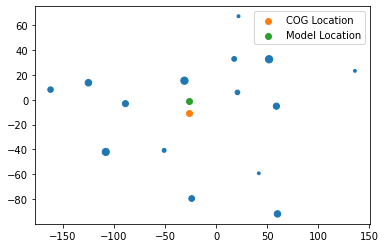

In [58]:
plt.scatter(df['x'], df['y'], s = df['demand']/100)
plt.scatter(x_cog, y_cog, label="COG Location")
plt.scatter(x_opt, y_opt, label="Model Location")
plt.legend()

## Integer and Linear Programming Locations

In [62]:
#Objective Function
D = []
for _, row in df.iterrows():
    dx = row['x'] - df['x']
    dy = row['y'] - df['y']
    d = (dx**2 + dy**2)**0.5
    D.append(d.values)
D = np.array(D)

nCity = len(df)
V = set(range(nCity))
demand = df['demand']
nw = 3

m = Model('Multiple Warehouses')

y = [[m.add_var(var_type=BINARY) for i in V] for j in V]

m.objective = \
minimize(xsum([xsum(
    [y[i][j] * D[i][j] * demand[j] for i in V]) for j in V]))

#Constraints
for j in V: 
    m += xsum([y[i][j] for i in V])==1
    
m += xsum([y[i][i] for i in V]) == nw #nw1 #nw2

for i in V: 
    for j in V: 
        if i != j: 
            m += y[i][j] <= y[i][i]

m.optimize()


<OptimizationStatus.OPTIMAL: 0>

In [66]:
warehouses1 = [i for i in V if y[i][i].x>0.5]
warehouses1

[3, 6, 12]

In [69]:
flow1 = [[y[i][j].x for j in V] for i in V]
#flow1

In [70]:
[flow1[i] for i in warehouses1]

[[1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0],
 [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0]]

In [74]:
distances_cap = D[warehouses1].round(1)

In [79]:
capacity = [20000] * nw
sum(capacity), sum(demand)

(60000, 46660.0)

In [85]:
#Defined MIP Model 
m = Model()
f = [[m.add_var(var_type=CONTINUOUS, lb=0) for j in V] for i in range(nw)]

total_distances_cap = xsum([xsum([distances_cap[i][j]*f[i][j] for j in V]) for i in range(nw)])

m.objective = minimize(total_distances_cap)

In [91]:
#Capacity Contraint 
for i in range(nw): 
    m += xsum([f[i][j] for j in V]) <= capacity[i]
    
#Demand Constraint 
for j in V: 
    m += xsum([f[i][j] for i in range(nw)])== demand[j]

In [92]:
m.optimize()

<OptimizationStatus.OPTIMAL: 0>

In [93]:
[[f[i][j].x for j in V] for i in range(nw)

[[4270.0,
  0.0,
  0.0,
  3680.0,
  0.0,
  3070.0,
  0.0,
  5090.0,
  0.0,
  0.0,
  2350.0,
  0.0,
  0.0,
  0.0,
  1540.0],
 [0.0,
  790.0,
  0.0,
  0.0,
  0.0,
  0.0,
  4140.0,
  0.0,
  0.0,
  3350.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 [0.0,
  0.0,
  2190.0,
  0.0,
  3860.0,
  0.0,
  0.0,
  0.0,
  2320.0,
  0.0,
  2960.0,
  800.0,
  5350.0,
  900.0,
  0.0]]

In [107]:
#Amount in each WH
pd.DataFrame([sum([f[i][j].x for i in range(nw)]) for j in V])

,0
0,4270.0
1,790.0
2,2190.0
3,3680.0
4,3860.0
5,3070.0
6,4140.0
7,5090.0
8,2320.0
9,3350.0


In [115]:
locations = df[['name', 'x', 'y']].iloc[warehouses1]
locations

,name,x,y
3,D,-88.803093,-3.120039
6,G,60.158522,-91.886845
12,M,51.904766,32.616293


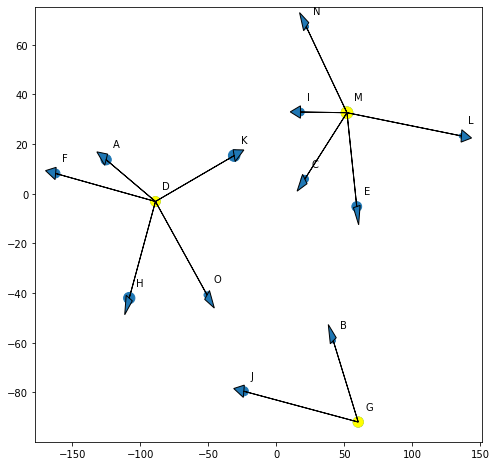

In [114]:
fig, ax = plt.subplots(figsize=(8,8))


plt.scatter(df['x'], df['y'], s = df['demand']//40)
plt.scatter(df.iloc[warehouses1]['x'], 
           df.iloc[warehouses1]['y'], color = 'Yellow', s = df.iloc[warehouses1]['demand']//40)


for i in range(nCity):
    ax.annotate(
    df.iloc[i]['name'], 
    df.iloc[i][['x', 'y']].values +5)

for wh in warehouses1: 
    dest = [j for j in V-{wh} if y[wh][j].x == 1]
    xi, yi = df.iloc[wh][['x', 'y']]
    for j, row in df.iterrows(): 
        if j in dest: 
            xj, yj = df.iloc[j][['x', 'y']]
            dx = xj - xi 
            dy = yj - yi
            plt.arrow(xi, yi, dx, dy, head_width=5)